# Demo of a decision tree Leo transpilation for the MNIST dataset

Using a decision tree to classify images on datasets like the MNIST dataset may seem a bit of an unusual approach - but we want to show it is possible, even in a zero-knowledge environment! Inspired by [this project](https://www.kaggle.com/code/carlolepelaars/97-on-mnist-with-a-single-decision-tree-t-sne), the trick is to transform the data before passing it to the decision tree. We use the techniques of ??? and t-SNE to reduce the dataset dimensionality and make it separable by a decision tree

## Function to download the dataset

In [1]:
import gzip
import os
import shutil

import requests


def download_and_extract_dataset(url, save_path, folder_path):
    """Download and extract dataset if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        response = requests.get(url)
        with open(save_path, "wb") as file:
            file.write(response.content)

        decompressed_file_name = os.path.splitext(os.path.basename(save_path))[0]
        decompressed_file_path = os.path.join(folder_path, decompressed_file_name)

        with gzip.open(save_path, "rb") as f_in:
            with open(decompressed_file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f"{decompressed_file_name} downloaded and extracted.")
    else:
        print(f"{os.path.basename(save_path)} already exists.")

## Download the dataset

In [2]:
# URLs and filenames
file_info = [
    (
        "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
    ),
]

folder_name = "tmp/mnist"
folder_path = os.path.join(os.getcwd(), folder_name)

os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

# Download and extract each file
for url, file_name in file_info:
    path_to_save = os.path.join(folder_path, file_name)
    download_and_extract_dataset(url, path_to_save, folder_path)

train-images-idx3-ubyte.gz already exists.
train-labels-idx1-ubyte.gz already exists.
t10k-images-idx3-ubyte.gz already exists.
t10k-labels-idx1-ubyte.gz already exists.


In [3]:
import numpy as np


def read_idx3_ubyte_image_file(filename):
    """Read IDX3-ubyte formatted image data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_images = int.from_bytes(f.read(4), byteorder="big")
        num_rows = int.from_bytes(f.read(4), byteorder="big")
        num_cols = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2051:
            raise ValueError(f"Invalid magic number: {magic_num}")

        images = np.zeros((num_images, num_rows, num_cols), dtype=np.uint8)

        for i in range(num_images):
            for r in range(num_rows):
                for c in range(num_cols):
                    pixel = int.from_bytes(f.read(1), byteorder="big")
                    images[i, r, c] = pixel

    return images


def read_idx1_ubyte_label_file(filename):
    """Read IDX1-ubyte formatted label data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_labels = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2049:
            raise ValueError(f"Invalid magic number: {magic_num}")

        labels = np.zeros(num_labels, dtype=np.uint8)

        for i in range(num_labels):
            labels[i] = int.from_bytes(f.read(1), byteorder="big")

    return labels


# Example usage
folder_path = os.path.join(
    os.getcwd(), folder_name
)  # Adjust this path to where you stored the files

train_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "train-images-idx3-ubyte")
)
train_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "train-labels-idx1-ubyte")
)
test_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "t10k-images-idx3-ubyte")
)
test_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "t10k-labels-idx1-ubyte")
)

print(
    f"Shape of train_images: {train_images.shape}"
)  # Should output "Shape of train_images: (60000, 28, 28)"
print(
    f"Shape of train_labels: {train_labels.shape}"
)  # Should output "Shape of train_labels: (60000,)"
print(
    f"Shape of test_images: {test_images.shape}"
)  # Should output "Shape of test_images: (10000, 28, 28)"
print(
    f"Shape of test_labels: {test_labels.shape}"
)  # Should output "Shape of test_labels: (10000,)"

Shape of train_images: (60000, 28, 28)
Shape of train_labels: (60000,)
Shape of test_images: (10000, 28, 28)
Shape of test_labels: (10000,)


In [4]:
# Reshape the datasets from 3D to 2D
train_images_2d = train_images.reshape(
    train_images.shape[0], -1
)  # -1 infers the size from the remaining dimensions
test_images_2d = test_images.reshape(test_images.shape[0], -1)

# Create the classifier and fit it to the reshaped training data
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf.fit(train_images_2d, train_labels)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [5]:
from sklearn.metrics import accuracy_score


def acc(y_true, y_pred):
    return accuracy_score(y_true, y_pred) * 100  # Multiply by 100 to get percentage


# Evaluate the baseline model
train_preds_baseline = clf.predict(train_images_2d)
val_preds_baseline = clf.predict(test_images_2d)
acc_baseline_train = acc(train_preds_baseline, train_labels)
acc_baseline_val = acc(val_preds_baseline, test_labels)
print(
    f"Training accuracy for our baseline (using all pixel features): {acc_baseline_train:.2f}%"
)
print(
    f"Validation accuracy for our baseline (using all pixel features): {acc_baseline_val:.2f}%"
)

Training accuracy for our baseline (using all pixel features): 89.95%
Validation accuracy for our baseline (using all pixel features): 86.57%


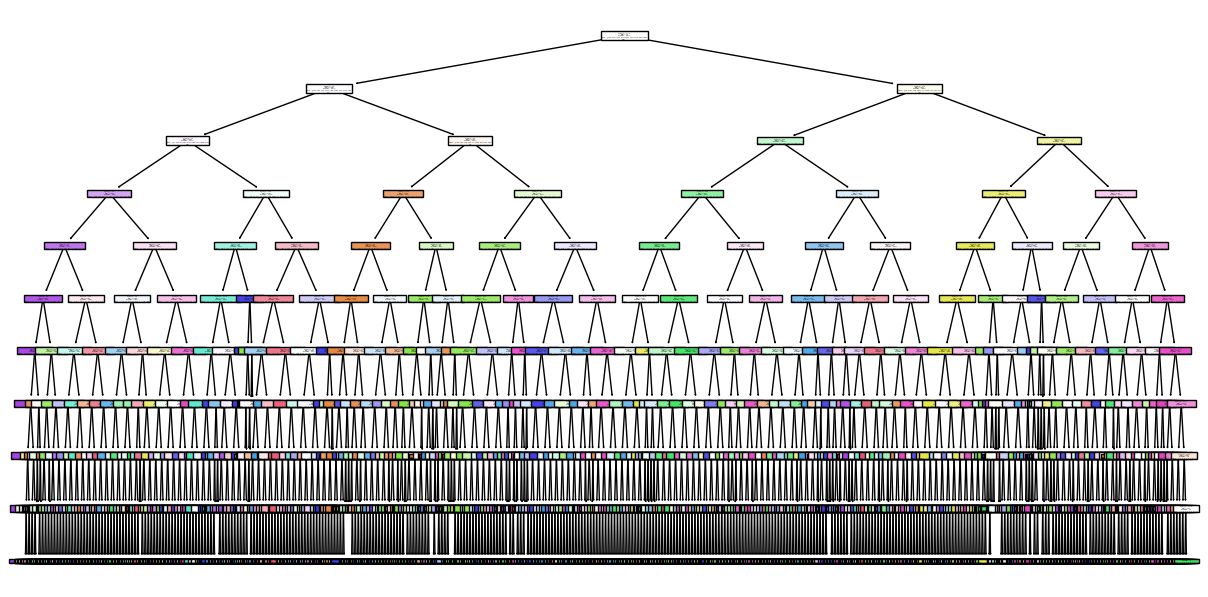

In [6]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 7.5))
plot_tree(clf, filled=True)
plt.show()

In [7]:
import logging
import os

from leotranspiler import LeoTranspiler

# Set the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Transpile the deceision tree into Leo code
lt = LeoTranspiler(model=clf, validation_data=train_images_2d[0:50])
leo_project_path = os.path.join(os.getcwd(), "tmp/mnist")
leo_project_name = "tree_credit"
lt.to_leo(path=leo_project_path, project_name=leo_project_name)

INFO:root:Computing number ranges and fixed-point scaling factor...
INFO:root:Minimum number: -2.0, maximum number: 255. Recommended fixed-point scaling factor: 16, required Leo type: i16
INFO:root:Transpiling model...
INFO:root:Leo program stored


In [8]:
# prove and compare the Leo prediction with the Python prediction and the label
zkp = lt.execute(input_sample=train_images_2d[0])
python_prediction = clf.predict([train_images_2d[0]])

print(f"Circuit constraints: {zkp.circuit_constraints}")
print(f"Active input count: {zkp.active_input_count}")
print(f"Leo prediction in fixed-point notation: {zkp.output[0]}")
print(f"Leo prediction in decimal notation: {zkp.output_decimal[0]}")
print(f"Python prediction: {python_prediction[0]}")
print(f"Label: {test_labels[0]}")

Circuit constraints: 27116
Active input count: 326
Leo prediction in fixed-point notation: 80
Leo prediction in decimal notation: 5.0
Python prediction: 5
Label: 7


In [9]:
from sklearn.decomposition import TruncatedSVD

# Fit the model to the training data
tsvd = TruncatedSVD(n_components=50)
tsvd.fit(train_images_2d)

# Transform both training and test datasets using the fitted model
train_tsvd = tsvd.transform(train_images_2d)
test_tsvd = tsvd.transform(test_images_2d)

In [10]:
# Train model with t-svd features
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf.fit(train_tsvd, train_labels)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [11]:
# Evaluate the tsvd model
train_preds_tsvd = clf.predict(train_tsvd)
val_preds_tsvd = clf.predict(test_tsvd)
acc_tsvd_train = acc(train_preds_tsvd, train_labels)
acc_tsvd_val = acc(val_preds_tsvd, test_labels)
print(
    f"Training accuracy for our tsvd (using all pixel features): {acc_tsvd_train:.2f}%"
)
print(
    f"Validation accuracy for our tsvd (using all pixel features): {acc_tsvd_val:.2f}%"
)

Training accuracy for our tsvd (using all pixel features): 85.02%
Validation accuracy for our tsvd (using all pixel features): 81.55%


In [13]:
from parametric_tSNE import Parametric_tSNE

train_data = train_tsvd

high_dims = train_data.shape[1]
num_outputs = 2
perplexity = 30
ptSNE = Parametric_tSNE(high_dims, num_outputs, perplexity)
ptSNE.fit(train_data)
output_res = ptSNE.transform(train_data)

1875/1875 [==============================] - 2s 1ms/step


In [14]:
test_res = ptSNE.transform(test_tsvd)

313/313 [==============================] - 0s 942us/step


In [24]:
print(len(output_res))
print(output_res[0])

60000
[ 779.03143 -601.6753 ]


In [27]:
# transform output_res to a pandas dataframe
import pandas as pd

df = pd.DataFrame(output_res, columns=["x", "y"])

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

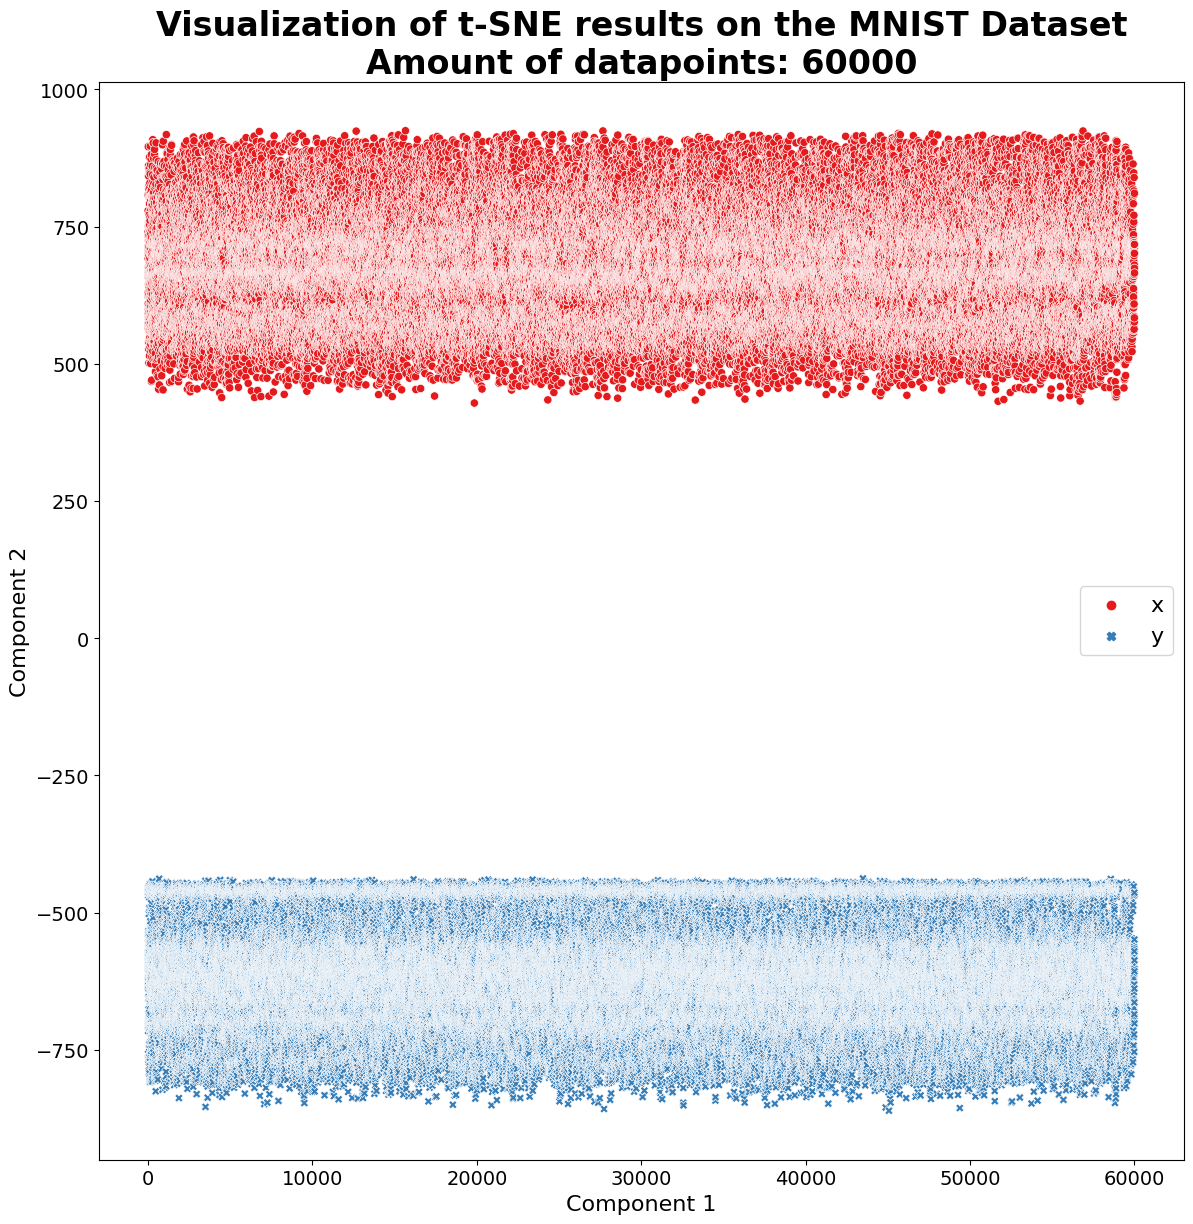

In [29]:
import seaborn as sns
# Visualize the results for t-SNE on MNIST
plt.figure(figsize=(14, 14))
plt.title(f"Visualization of t-SNE results on the MNIST Dataset\n\
Amount of datapoints: {len(df)}", fontsize=24, weight='bold')
sns.scatterplot(data=df, 
                palette="Set1", legend="full")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Component 1", fontsize=16)
plt.ylabel("Component 2", fontsize=16)
plt.legend(fontsize=16);

In [30]:
clf = DecisionTreeClassifier(max_depth=10, random_state=0)
clf.fit(output_res, train_labels)



DecisionTreeClassifier(max_depth=10, random_state=0)

In [31]:
# Evaluate the model
train_preds_tsvd = clf.predict(output_res)
val_preds_tsvd = clf.predict(test_res)
acc_tsvd_train = acc(train_preds_tsvd, train_labels)
acc_tsvd_val = acc(val_preds_tsvd, test_labels)
print(
    f"Training accuracy for our tsvd (using all pixel features): {acc_tsvd_train:.2f}%"
)
print(
    f"Validation accuracy for our tsvd (using all pixel features): {acc_tsvd_val:.2f}%"
)

Training accuracy for our tsvd (using all pixel features): 80.31%
Validation accuracy for our tsvd (using all pixel features): 78.77%
